# **Part 2**


1. Implementation of **LoG blob detection algorithm** to detect flowers in the given flowers.png picture. This part also includes comparison between the method implemented from scratch and the one provided by OpenCV library.
2. Implementation of LoG with **normalized scale variations**. [A multiscale Laplacian of Gaussian(LoG) filtering approach to pulmonary nodule detection from
whole-lung CT scans](https://arxiv.org/pdf/1907.08328.pdf)
3. Performance of additional experiments with different **threshold values** for both algorithms.



## Implementation of unnormalized Lapalacian of Gaussian filter for blob detection
**The idea:** Convolve an image with multiple different-scale "blob" filters and look for the zero-crossings in order to find edges in the specific scale space.

Laplacian is a second-order derivative scale invariant filter. Unlike first-order filters, Laplacian detects the edges at zero crossings i.e. where the value changes from negative to positive and vice-versa. To reduce the noise effect, image is first smoothed with a Gaussian filter and then we find the zero crossings using Laplacian. This two-step process is called the Laplacian of Gaussian (LoG) operation. 

$$
LoG(x,y) = -\frac{1}{\pi \sigma^4} \left [1 - \frac{x^2 + y^2}{2 \sigma^2} \right] \exp^{- \frac{x^2 + y^2}{2 \sigma^2}}
$$

In [63]:
#!pip install scikit-image

To have an idea about what kind of output we should expect from implemented algorith we decided to firs run the LoG function available in the scikit-image library.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
import scipy


In [13]:
# Read image
img = io.imread('../images/flowers.png')

# Convert to grayscale
img_gray = color.rgb2gray(img)

In [44]:
def draw_circles(img, blobs, cmap='CMRmap'):
    # the raius is approximate sqrt(2)*sigma

    sigma = 1
    k = np.sqrt(2)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=cmap)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r*np.sqrt(2), color='white', linewidth=2, fill=False)
        ax.add_patch(c)

    return fig, ax

In [70]:
def draw_circles_multi(img, coordinates, cmap='CMRmap', titles = []):

    fig, ax = plt.subplots(1, len(coordinates), figsize=(20, 20))
    
    for i, coordinate in enumerate(coordinates):        
        ax[i].imshow(img, cmap=cmap)
        for blob in coordinate:
            y, x, r = blob
            c = plt.Circle((x, y), r*np.sqrt(2), color='red', linewidth=2, fill=False)
            ax[i].add_patch(c)


    return fig, ax

As we can see in the output image, although algorithm did define some blobs correctly, overall performance is not very good, it primarily targets area around the flower center rather than the center itself. Let's implement LoG from scratch, define more tuned parameters, and compare results of both algorithms.

In [82]:
# definitions of second derivate Gaussian and Laplacians

def gaussian_2d(x, y, A=1, x0=0, y0=0, sigma=1):
    return A * np.exp(-( (x - x0)**2 / (2 * sigma**2) + (y - y0)**2 / (2 * sigma**2)))

def laplacian_2d(sigma=1):
    
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]

    return -(1/(np.pi*sigma**4)) * (1- ((x**2 + y**2) / (2*sigma**2))) * np.exp(-(x**2+y**2)/(2*sigma**2))


In [48]:
def log_image(img_gray, n_kernels=9, threshold=0.2):

    """
    :param img: input image HAS TO BE GRAYSCALE (or single channel)    
    :param min_sigma: minimum sigma value
    :param max_sigma: maximum sigma value
    :param steps: number of steps
    :return: log image        
    """

    k = np.sqrt(2)
    sigma = 1

    kernels = []
    log_images = []
    sigma_list = []    

    # threshold the log images
    log_images_thresholded = []

    for i in range(0,n_kernels):
        sigma_curr = sigma * k**i
        sigma_list.append(sigma_curr)
            
        kernel_log = laplacian_2d(sigma=sigma_curr)
        kernels.append(kernel_log)

        log_image = scipy.signal.convolve2d(img_gray, kernel_log, mode='same', boundary='symm')
        log_images.append(log_image)

        log_image_thresholded = np.zeros_like(log_images[i])
        log_image_thresholded[log_images[i] >= max(log_images[i].flatten())-(threshold * max(log_images[i].flatten()))] = 1
        log_images_thresholded.append(log_image_thresholded)
    
    log_images_np = np.array(log_images)

    return log_images_np, kernels, np.array(log_images_thresholded), sigma_list

In [49]:
def print_steps(log_images_np, kernels, log_images_thresholded, sigma_list):

    n_kernels = np.shape(log_images_np)[0]

    # plot the kernels
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(kernels[i], cmap='gray')        
        axs[i].set_title('σ {:.5f}'.format(sigma_list[i]))

    # plot the log images
    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(n_kernels):
        axs[i].imshow(log_images_np[i], cmap='gray')
        axs[i].set_title('σ {:.2f} max{:.2f} min{:.2f}'.format(sigma_list[i], max(log_images_np[i].flatten()), min(log_images_np[i].flatten())))

    fig, axs = plt.subplots(1, n_kernels, figsize=(20, 20))
    for i in range(np.shape(log_images_np)[0]):        
        axs[i].imshow(log_images_thresholded[i], cmap='gray')
        axs[i].set_title('σ {:.2f} max{:.2f} min{:.2f}'.format(sigma_list[i],  max(log_images_thresholded.flatten()), min(log_images_thresholded.flatten())))

    fig, axs = plt.subplots(1, np.shape(log_images_thresholded)[0], figsize=(20, 20))
    for i in range(np.shape(log_images_thresholded)[0]):
        img_test = img.copy()
        img_test[log_images_thresholded[i] == 1] = 255
        axs[i].imshow(img_test)



Here you can see all of the steps that are being taken in order to further detect the "blobs. First row displays" the impact of each sigma value on the kernel and its values - those are kernels used for convolution. Second row shows the imact of the convolution operation on the original image with regard to sigma. Last line shows how thresholding  impacts the number of blobs that are "activated" after LoG filter. More on that in the last part of this task.

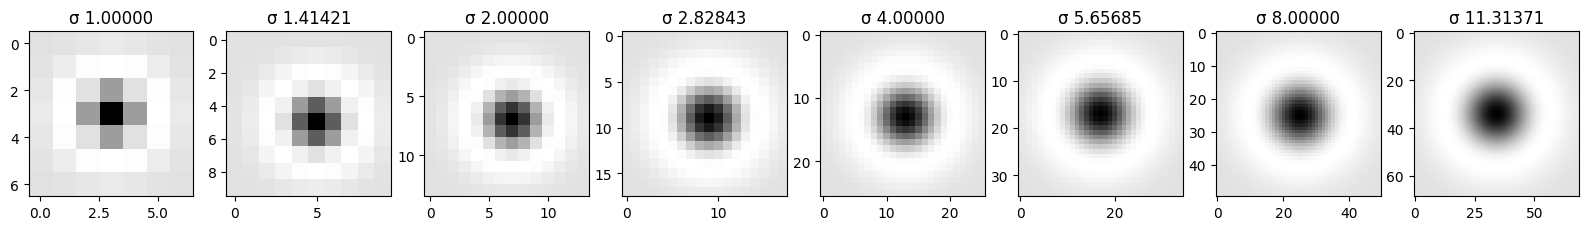

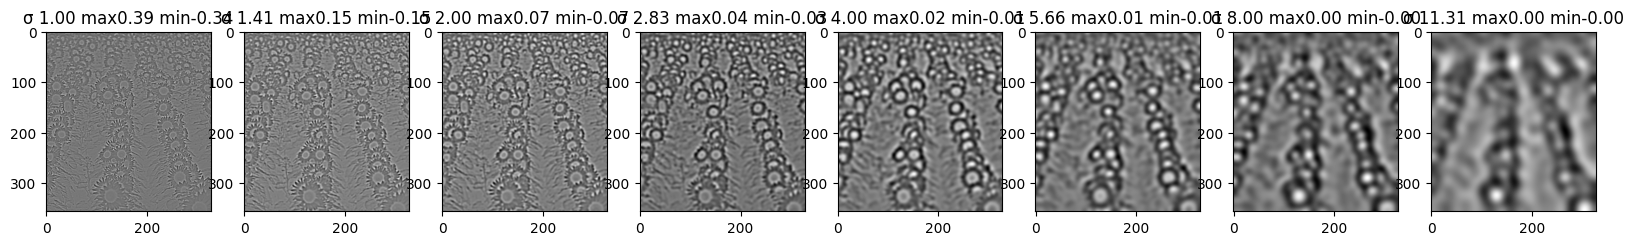

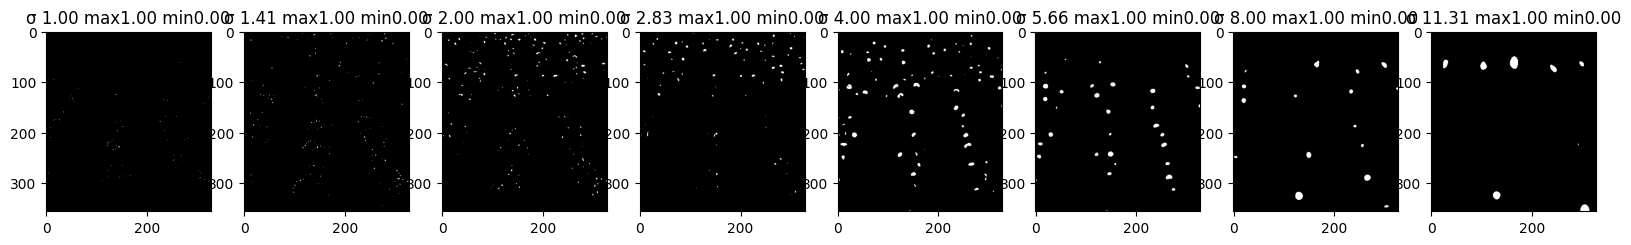

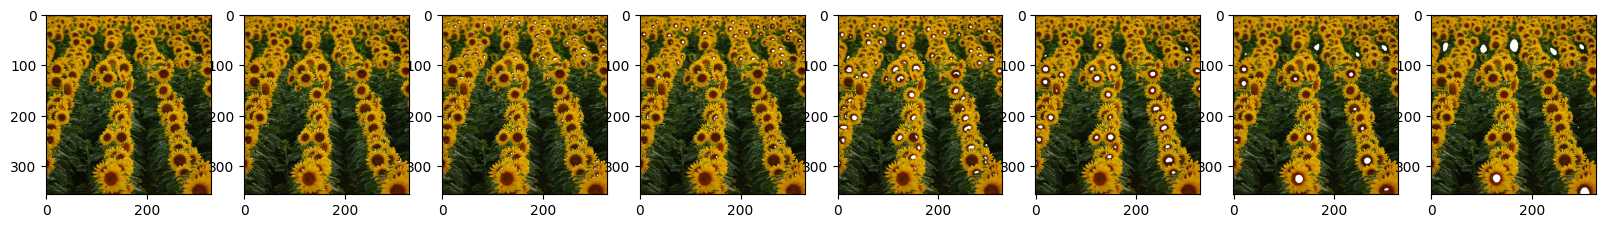

In [83]:
log_images_np, kernels, log_images_thresholded, sigma_list = log_image(img_gray, 8, threshold=0.4)

print_steps(log_images_np, kernels, log_images_thresholded, sigma_list)

(370, 370, 3)
255.0
(370, 370, 3)


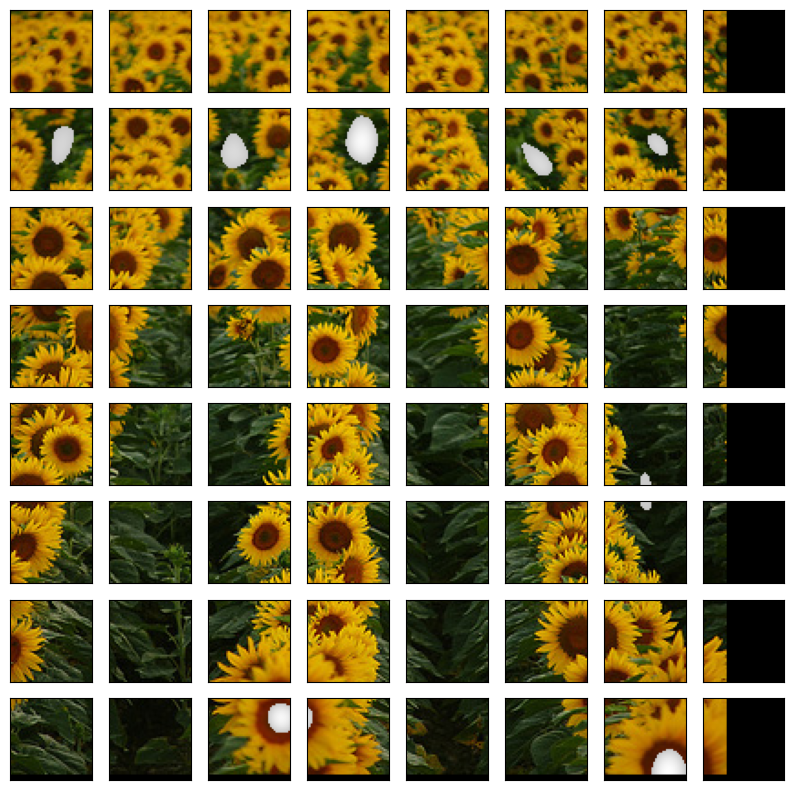

In [84]:

size = 45
padd_x = img.shape[0]%size
padd_y = img.shape[1]%size

index = 7

log_image_np = log_images_np[index].copy()

# convert log image to rgb
log_image_np = (log_image_np - min(log_image_np.flatten()))
log_image_np_1 = (log_image_np / max(log_image_np.flatten()))

log_image_rgb = color.gray2rgb(log_image_np_1)

img_padded = np.pad(img, ((0,padd_y),(0,padd_x),(0,0)), 'constant', constant_values=0)
log_image_thresholded_padded = np.pad(log_images_thresholded, ((0,0),(0,padd_y),(0,padd_x)), 'constant', constant_values=0)
log_image_rgb = np.pad(log_image_rgb, ((0,padd_y),(0,padd_x), (0,0)), 'constant', constant_values=0)
log_image_rgb = log_image_rgb * 255

print(log_image_rgb.shape)

print(max(log_image_rgb.flatten()))

threshold = 200

print(img_padded.shape)
fig, axs = plt.subplots(len(img_padded)//size, len(img_padded)//size, figsize=(10, 10))

for i in range(len(img_padded)//size):
    for j in range(len(img_padded)//size):
        img_test = img_padded.copy()
        img_test[log_image_rgb > threshold] = log_image_rgb[log_image_rgb > threshold]
        #axs[i].imshow(img_test)
        axs[i,j].imshow(img_test[i*size:(i+1)*size,j*size:(j+1)*size,:])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

    

In [85]:
def detect_blob_v2(log_images_np, k = np.sqrt(2), sigma = 1, percentage_high = 0.5):
    co_ordinates = []    

    co_ordinates = [[] for i in range(log_images_np.shape[0])]        

    for z in range(log_images_np.shape[0]):

        size = int(np.ceil(sigma * k**z)) * 5        

        padd_y = img.shape[0]%size
        padd_x = img.shape[1]%size        

        log_images_np_padded = np.pad(log_images_np[z], ((0,padd_x),(0,padd_y)), constant_values=0)                

        (h,w) = log_images_np_padded.shape                          
        
        threshold = max(log_images_np[z].flatten())-(percentage_high * max(log_images_np[z].flatten()))

        for i in range(int(size//2),int(h-size//2), size):
            for j in range(int(size//2), int(w-size//2), size):                
                
                slice_img = log_images_np[z,i-size//2:i+size//2,j-size//2:j+size//2]                                
                x_max, y_max = np.unravel_index(np.argmax(slice_img), slice_img.shape)
                
                if slice_img[x_max, y_max] > threshold:
                    co_ordinates[z].append((i+x_max-size//2,j+y_max-size//2,(k**z)*sigma))                         

    return co_ordinates

(<Figure size 2000x2000 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

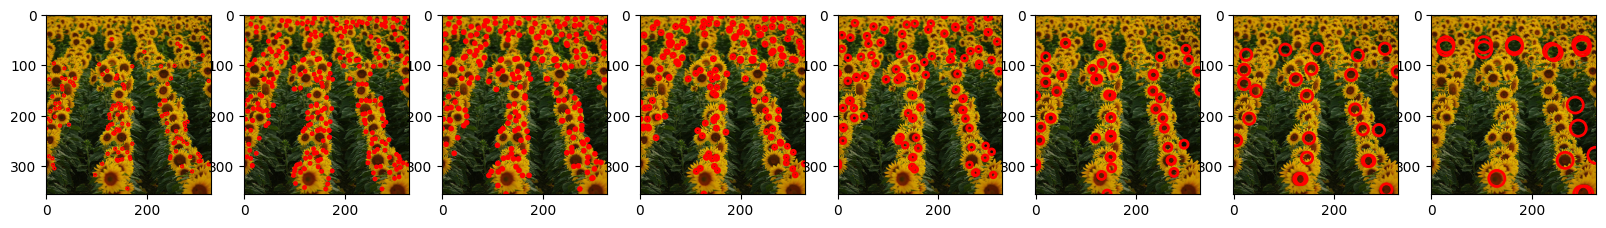

In [86]:
coordinates = detect_blob_v2(log_images_np)
draw_circles_multi(img, coordinates)

In [87]:
def flatten_array_coordinates(coordinates):
    return [item for scale in coordinates for item in scale]

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

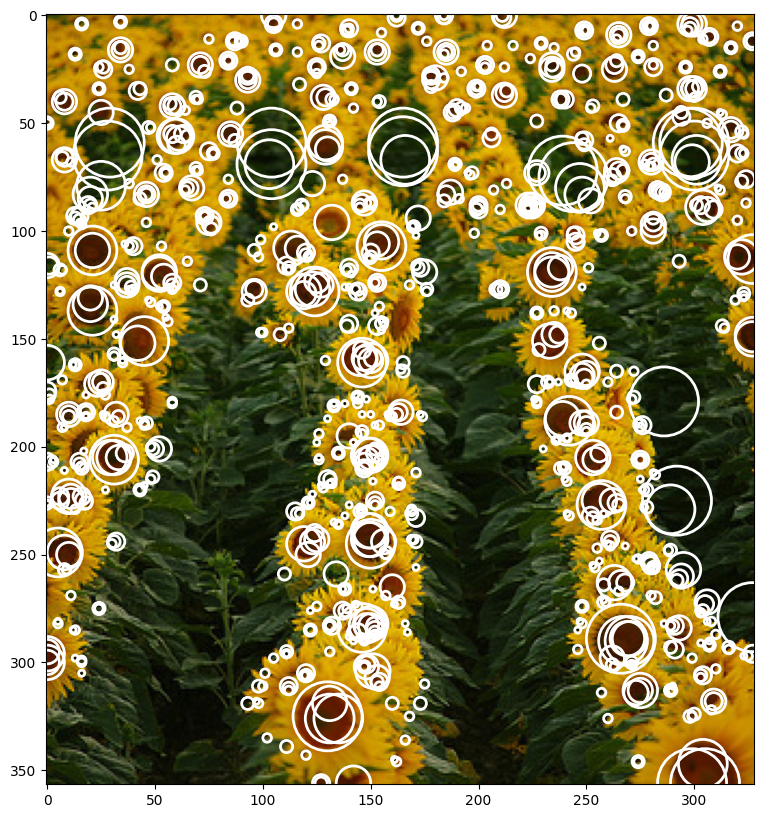

In [88]:
coordinates_1d = flatten_array_coordinates(coordinates)
draw_circles(img, coordinates_1d)

In [67]:
def non_max_suppression(coordinates, threshold = 1):    

    print("before", len(coordinates))

    curr_coordinates = coordinates[::-1]    

    tmp_lenght = len(curr_coordinates)

    i = 0

    while(i < tmp_lenght):
        j = i+1
        while j < tmp_lenght:            

            x1, y1, r1 = curr_coordinates[i]
            x2, y2, r2 = curr_coordinates[j]
            
            distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)

            if distance < threshold * (r1+r2):
                curr_coordinates.pop(j)
                tmp_lenght -= 1
                j -= 1

            j += 1

        i += 1        

    print("after", len(curr_coordinates))

    return curr_coordinates[::-1]


In [89]:
# performing non max suppression in order to minimize blob overlapping in the image
res = non_max_suppression(coordinates_1d)

before 996
after 395


(<Figure size 2000x2000 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

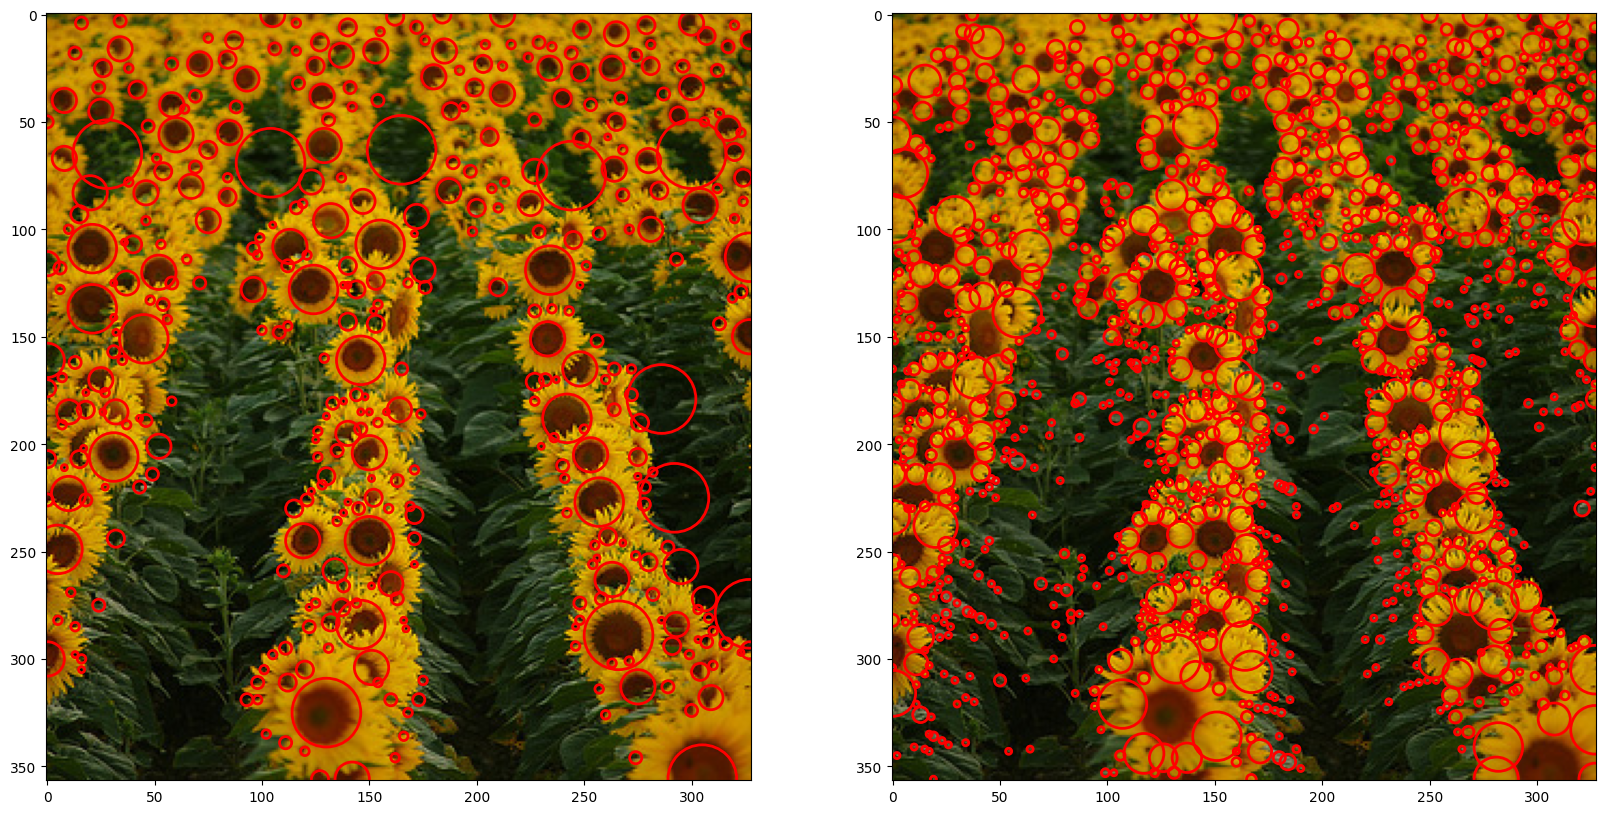

In [90]:
res_skimage = feature.blob_log(img_gray, min_sigma=1, max_sigma=8, num_sigma=50, threshold=.1, overlap=.5, log_scale=False, exclude_border=False)

draw_circles_multi(img, list([res, res_skimage]))

## Test with light blobs

(<Figure size 2000x2000 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

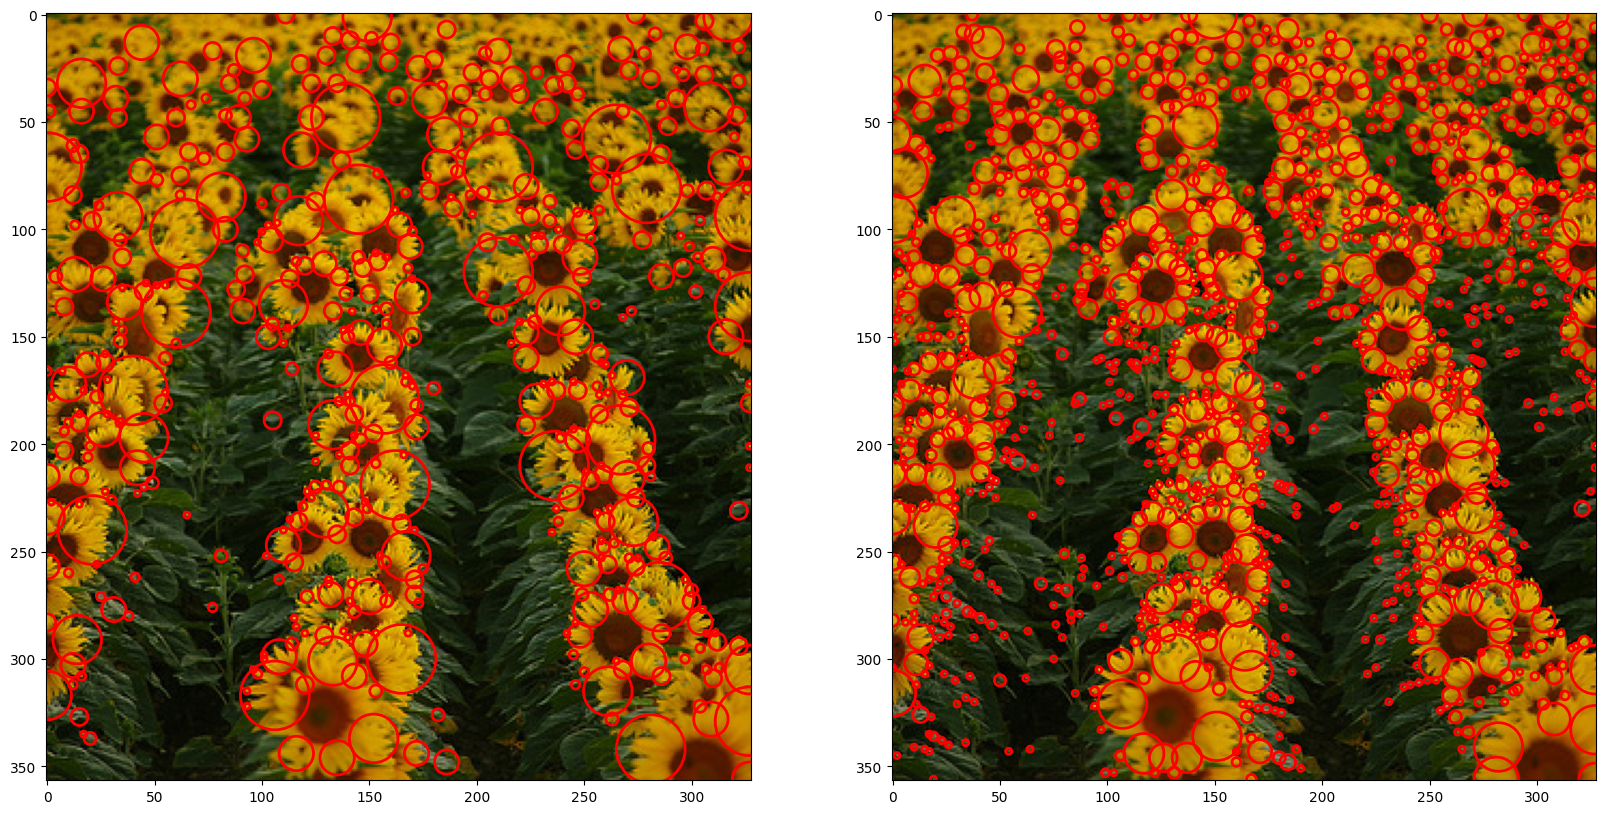

In [80]:

#res_skimage = feature.blob_log(img_gray, min_sigma=1, max_sigma=8, num_sigma=50, threshold=.1, overlap=.5, log_scale=False, exclude_border=False)

# draw_circles_multi(img, list([res, res_skimage]))

As we can see when compating the algorithm from scratch (left) to the pre-build one from skimage (right), we can see that hand built algorithm actually has less outliers and targets the values that correspond to the flower centers, while the pre-build one has a lot more of small, let's say 'noisy' circles that don't contribute to the blobs, which gives the feeling that it targets highlights rather that the dark spots. As per the outliers in the from-scratch algorithm, they can be removed with the help of "normalization". We will talk about it in the next section.

### Different thresholds testing

In [92]:
coordinates_diff_threshold = []

thresholds = [0.2,0.3,0.4,0.5,0.7,0.9]

for x in thresholds:

    log_images_np, kernels, log_images_thresholded, sigma_list = log_image(img_gray, 8)        

    coordinates = detect_blob_v2(log_images_np, percentage_high=x)

    coordinates_1d = flatten_array_coordinates(coordinates)

    res = non_max_suppression(coordinates_1d)

    coordinates_diff_threshold.append(res)

titles = ["Threshold: " + i for x in thresholds]
print(titles)

draw_circles_multi(img, coordinates_diff_threshold, titles=titles)
    

before 107
after 68
before 249
after 145
before 553
after 256
before 996
after 395
before 2590
after 921
before 5728


## Implementation of normalized Lapalacian of Gaussian filter for blob detection
**The idea:** Increase effectiveness of the filtering of the original image with scale-normalized LoG kernels of continuously changing scale parameter.

Normalization is necessary to eliminate the effect of decreasing spatial derivatives with the increase of scale and is defined as the negated multiplication of LoG by σ2.

$$ 
L_{norm}(X, σ) 
$$ 
is the scale-space representation obtained for image I(X) by convolving it with normalized Gaussian kernel at continuous set of scales

$$
\nabla^2_{norm} L(X, \sigma) = \nabla^2_{norm} G(X, \sigma) * I(X)
$$

$$
\nabla^2_{norm} G(X, \sigma) = \sigma^2\nabla^2G(X, \sigma)
$$

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np

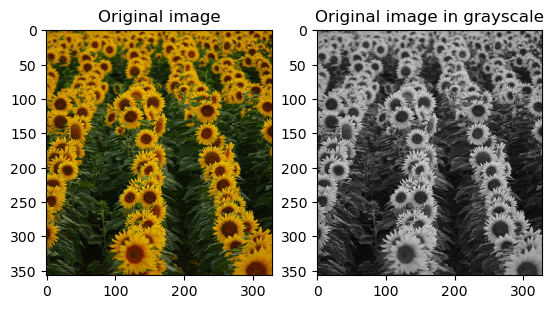

In [61]:
input_image = cv2.imread("../images/flowers.png")
image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# since given image is in .png format it was decided to use cv2 to read it, due to the fact that it
# removes 4th bin (alpha) that is taken into account if using skimage, for instance
# step with transforming image to rgb was made due to the fact that by default cv2 reads images in bgr - it was important to put colo channels back in place
# for LoG it is better to work with 1 parameter that would correspond to color (pixel intensity or color intensity), due to the fact that it explicitly works with intensity change and min-max response, that's why original image was converted into gray scale for experiments

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_rgb)
ax1.set_title("Original image")
ax2.imshow(image_gray, cmap='gray')
ax2.set_title("Original image in grayscale")
plt.show()

In [56]:
def create_normalized_log_kernel(sigma = 1.0):
    # Step 1: Creating normalized LoG filter/kernel template
    # calculating LoG kernel - mix of gaussian smoothing and laplacian second derivative to obtain kernel for convolving with the image in one step
    # main difference between this approach and the one without normalization is additional multiplier - np.square(sigma)
    # It  is necessary to eliminate the effect of decreasing spatial derivatives with the increase of scale (sigma)
    kernel_size = np.ceil(sigma * 6).astype(int)
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 4)) *
                    np.array([
                     - (2.0 * sigma ** 2) + (x - (kernel_size//2)) ** 2 + (y - (kernel_size//2)) ** 2
                    ]) *
                    np.exp(-(((x - (kernel_size//2)) ** 2 + (y - (kernel_size//2)) ** 2)) / (2.0 * sigma ** 2)),
        (kernel_size, kernel_size)
    )
    return (kernel).squeeze()
    

In [57]:
def convolve_image_with_log(image, conv_number = 6, sigma = 1.0, step_size = 1.27):
    # Step 2: Performing convolution
    # to be able to capture blos of different sizes it is important to perform convolutions with multiple filters, because the value of maximum response will never reach its peak, until the diameter of blob perfectly matches the object of interest
    # for this reason it is important to try multiple kernels - to enhance blob detection
    # in this case to try to approach reasonable set of values I decided to go with 6 convolutions
    convolved_image = np.zeros_like(image)
    convolved_images = []
    # based on the selected reference paper I picked step size of 1.27 and update function for sigma - sigma_i+1 = sigma_i * k
    for i in range(0, conv_number):
        filter = create_normalized_log_kernel(sigma)
        # convolving image with generated kernel
        convolved_image = cv2.filter2D(image, -1, filter)
        convolved_image = np.square(convolved_image)
        convolved_images.append(convolved_image)
        sigma = step_size * sigma
    return np.array([i for i in convolved_images])

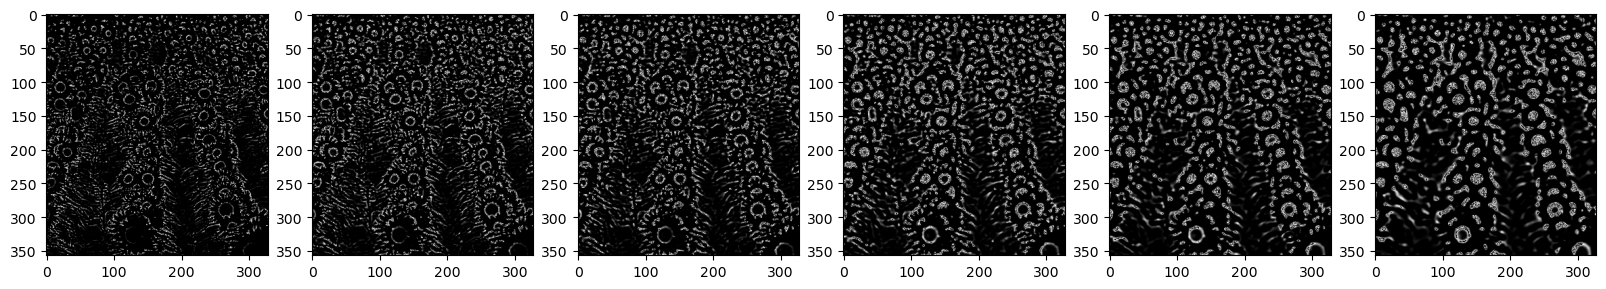

In [58]:
# plot the log images
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axs[i].imshow(convolve_image_with_log(image_gray)[i], cmap='gray')
    

In [59]:
def normalized_log_gray(image, sigma = 1.0, threshold = 0.03, conv_number = 6, step_size = 1.27):
    image = image/255.0
    convolved_images = convolve_image_with_log(image, conv_number, sigma, step_size)
    
    # Step 3: Finding local maximas This step finds local maxima in N-dimensional (conv_number) search space with respect to both location and scale.
    height, width = image.shape
    # here we will be finding the coordinates of the local maximas with respect to pixel positions (h - height, w - width) and dimension (n - which is one of the responses of te convolved image)
    maximums = [] 
    for i in range(1, height):
        for j in range(1, width):
            tile = convolved_images[:, i-1 : i+2, j-1 : j+2] 
            maximum = np.amax(tile)
            # threshold is important because for each pixel there will be a maximum, but not all of the pixels them contribute to blobs
            if maximum >= threshold:
                # dimension will help with finding exact sigma that was used to define that kernel and blob sizes targeted
                dimension , x_coord, y_coordinate = np.unravel_index(tile.argmax(),tile.shape)
                # each point is (original coordinte x, original coordinate y, radius size)
                maximums.append((i+x_coord-1, j+y_coordinate-1, sigma * np.power(step_size, dimension))) #finding co-rdinates
    
    maximums = list(set(maximums))       
    
    return maximums


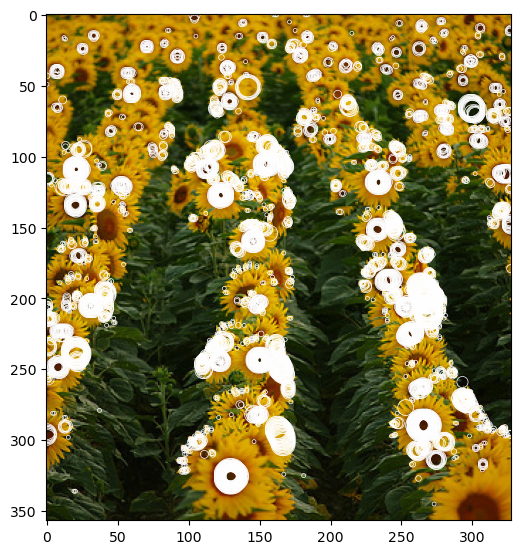

In [132]:
blobs = normalized_log_gray(image_gray, sigma=1.4, step_size=np.sqrt(2))

# Step 4: Drawing blobs

draw_circles(image_rgb, blobs)

## Additional experiments to analyse the impact of threshold on resulting blob detection